In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Importing data for payer 417740 as "data" and data for all payers included as "data_all".

In [3]:
data = pd.read_csv('data.csv')
data.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved,claim_reason,pa_feats
0,3,2.0,1,417740,A,76.0,0,1,0,0,1,CD,0
1,33,16.0,1,417740,A,76.0,0,1,1,1,0,CDTFCI,6
2,59,25.0,1,417740,A,76.0,0,1,0,0,1,CD,0
3,110,49.0,1,417740,B,70.0,0,1,0,0,0,CD,0
4,119,50.0,1,417740,B,70.0,0,1,0,0,0,CD,0


In [4]:
data_all = pd.read_csv('data_allpayers.csv')
data_all.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved,claim_reason,pa_feats
0,1,1.0,1,417380,A,75.0,0,1,1,0,1,CDTF,3
1,3,2.0,1,417740,A,76.0,0,1,0,0,1,CD,0
2,10,3.0,1,417380,A,75.0,0,0,0,1,1,CI,2
3,11,4.0,1,999001,A,76.0,0,1,1,0,1,CDTF,3
4,15,5.0,1,417614,A,70.0,0,0,1,0,1,TF,1


### Looking at distribution of 1s vs 0s

The following bar plot shows the total count of approved PAs(1) vs rejected PAs(0) irrespective of drug for each payer

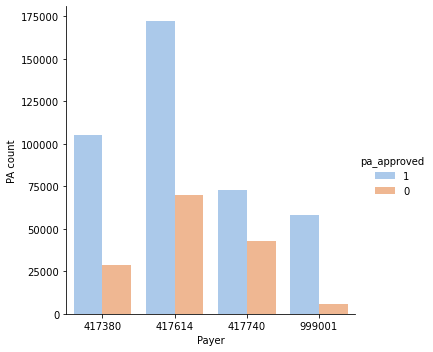

In [14]:
payer_plot=sns.catplot(x="bin", hue="pa_approved", kind="count",hue_order=[1,0],palette="pastel",data=data_all)
payer_plot.set_axis_labels("Payer","PA count")

The following bar plot shows the count of approved PAs(1) vs rejected PAs(0) for each drug for each payer

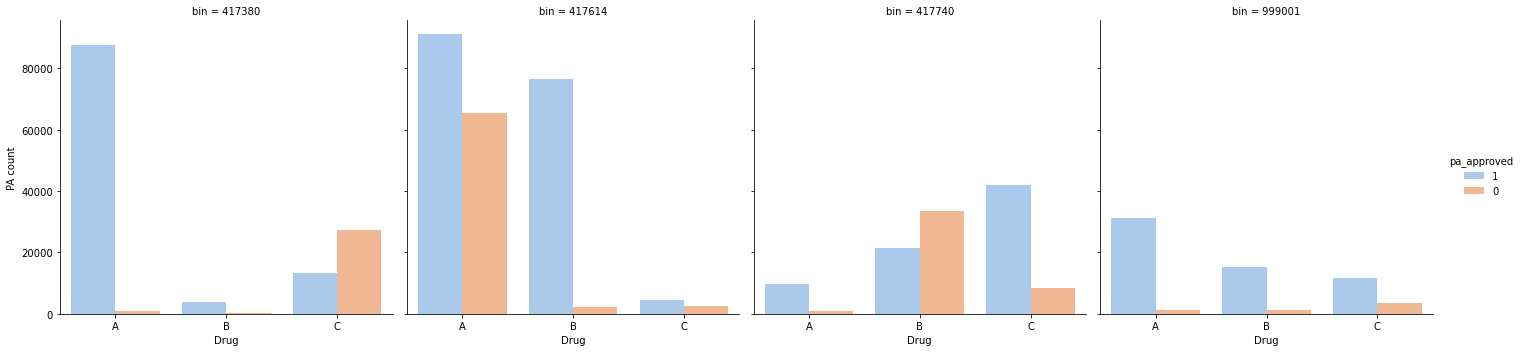

In [15]:
drug_plot=sns.catplot(x="drug", hue="pa_approved", kind="count",hue_order=[1,0],palette="pastel",col="bin",data=data_all)
drug_plot.set_axis_labels("Drug","PA count")

### Encoding the categoricals using dummy variables

In [5]:
## Encoding Claim features and Drugs for payer 417740 data
dummies = pd.get_dummies(data['claim_reason'],drop_first=True)
data = pd.concat([data,dummies], axis= 1)
data_drugs = data.copy()
dummies_drugs = pd.get_dummies(data['drug'],drop_first=True)
data_drugs = pd.concat([data_drugs,dummies_drugs], axis= 1)
data_drugs.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,...,pa_feats,CDCI,CDTF,CDTFCI,CI,None,TF,TFCI,B,C
0,3,2.0,1,417740,A,76.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,33,16.0,1,417740,A,76.0,0,1,1,1,...,6,0,0,1,0,0,0,0,0,0
2,59,25.0,1,417740,A,76.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,110,49.0,1,417740,B,70.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,119,50.0,1,417740,B,70.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
## Encoding Claim features, Drugs and Payer number for data_allpayers
dummies_all = pd.get_dummies(data_all['claim_reason'],drop_first=True)
data_all = pd.concat([data_all,dummies_all], axis= 1)
data_all_drugs = data_all.copy()
dummies_all_drugs = pd.get_dummies(data_all['drug'],drop_first=True)
data_all_drugs = pd.concat([data_all_drugs,dummies_all_drugs], axis= 1)
data_allpayers = data_all_drugs.copy()
dummies_allpayers = pd.get_dummies(data_all_drugs['bin'],drop_first=True)
data_allpayers = pd.concat([data_allpayers,dummies_allpayers], axis= 1)
data_allpayers.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,...,CDTFCI,CI,None,TF,TFCI,B,C,417614,417740,999001
0,1,1.0,1,417380,A,75.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3,2.0,1,417740,A,76.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,10,3.0,1,417380,A,75.0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,11,4.0,1,999001,A,76.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,15,5.0,1,417614,A,70.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


### Train-Test Split

In [7]:
## For single payer data(417740)
X_drugs = data_drugs[['B','C','CDCI','CDTF','CDTFCI','CI','None','TF','TFCI']]
y_drugs = data_drugs['pa_approved']
X_drugs_train, X_drugs_test,y_drugs_train,y_drugs_test = train_test_split(X_drugs,y_drugs,test_size=0.20,random_state=614,shuffle=True,stratify=y_drugs)

In [8]:
## For combined payers data
X_allpayers = data_allpayers[['B','C','CDCI','CDTF','CDTFCI','CI','None','TF','TFCI',417614,417740,999001]]
y_allpayers = data_allpayers['pa_approved']
X_allpayers_train, X_allpayers_test,y_allpayers_train,y_allpayers_test = train_test_split(X_allpayers,y_allpayers,test_size=0.20,random_state=614,shuffle=True,stratify=y_allpayers)

### Decision Tree Classifier

CV Mean Accuracy is [0.73457301 0.75667932 0.75675469 0.75650688 0.75650688 0.75650688
 0.75650688 0.75650688 0.75650688 0.75650688]
CV Mean Precision is [0.84711843 0.78548853 0.79624276 0.78982316 0.78982316 0.78982316
 0.78982316 0.78982316 0.78982316 0.78982316]
CV Mean Recall is [0.70589041 0.84416002 0.82511825 0.83618749 0.83618749 0.83618749
 0.83618749 0.83618749 0.83618749 0.83618749]


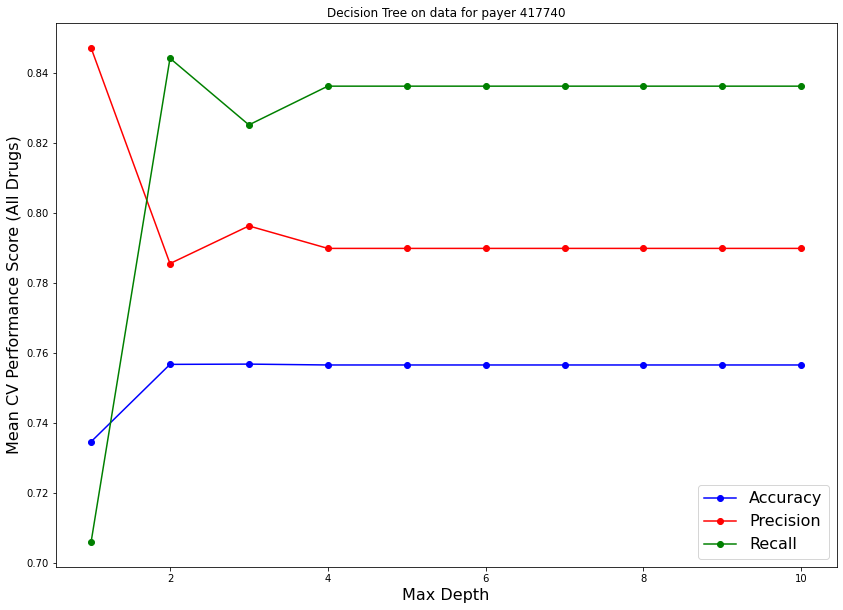

In [9]:
## For payer 417740 only
## Performing 10-fold Cross-validation while iterating max_depth
kfold = StratifiedKFold(n_splits=10,shuffle = True,random_state=440)
n=10
accs = np.zeros((10,n))
precs = np.zeros((10,n))
recs = np.zeros((10,n))
for j in range(1,n+1):
    tree_clf = DecisionTreeClassifier(max_depth=j,random_state=614)
    i=0
    for train_index,test_index in kfold.split(X_drugs_train,y_drugs_train):
        X_train_train,X_train_test = X_drugs_train.iloc[train_index],X_drugs_train.iloc[test_index]
        y_train_train,y_train_test = y_drugs_train.iloc[train_index],y_drugs_train.iloc[test_index]
    ## print(" for iteration",i,"X_train_train is",X_train_train,"and X_train_test is",X_train_test
    
        tree_clf_clone = clone(tree_clf)
        tree_clf_clone.fit(X_train_train,y_train_train)
        y_predict = tree_clf_clone.predict(X_train_test)
        accs[i,j-1] = accuracy_score(y_train_test,y_predict)
        precs[i,j-1] = precision_score(y_train_test,y_predict)
        recs[i,j-1] = recall_score(y_train_test,y_predict)
        i = i + 1

print("CV Mean Accuracy is",np.mean(accs,axis=0))
print("CV Mean Precision is",np.mean(precs,axis=0))
print("CV Mean Recall is",np.mean(recs,axis=0))

plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")

plt.ylabel("Mean CV Performance Score (All Drugs)",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)
plt.title("Decision Tree on data for payer 417740")

plt.show()

CV Mean Accuracy is [0.7344388  0.73856012 0.74208562 0.74799667 0.78318419 0.80091285
 0.80132431 0.80554007 0.8118963  0.81198174]
CV Mean Precision is [0.73853337 0.75361739 0.74233983 0.74745951 0.81703506 0.81841219
 0.81588504 0.82071437 0.83380185 0.83400972]
CV Mean Recall is [0.98907087 0.95729147 0.99376407 0.99221803 0.90830393 0.93689672
 0.94219283 0.94084584 0.92918522 0.92898317]


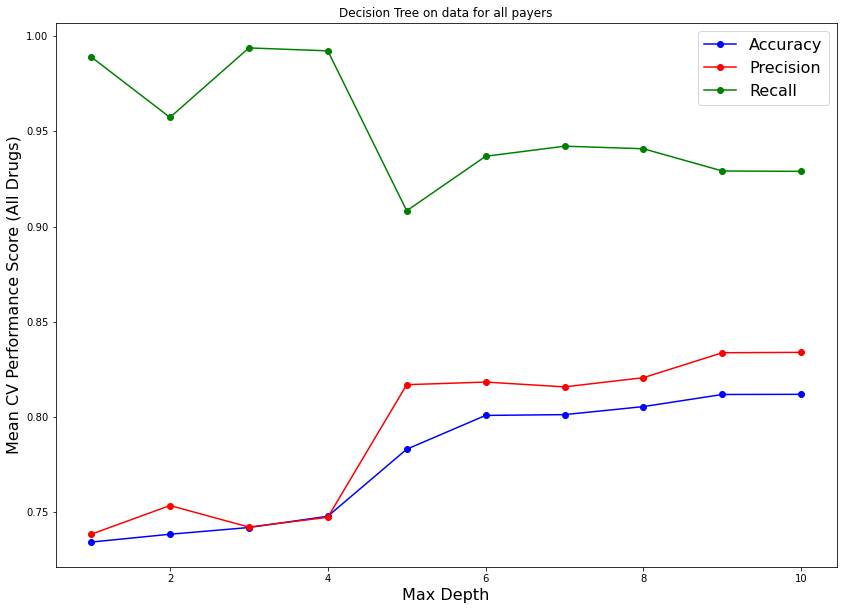

In [10]:
## For all payers combined
## Performing 10-fold Cross-validation while iterating max_depth
kfold = StratifiedKFold(n_splits=10,shuffle = True,random_state=440)
n=10
accs = np.zeros((10,n))
precs = np.zeros((10,n))
recs = np.zeros((10,n))
for j in range(1,n+1):
    tree_clf = DecisionTreeClassifier(max_depth=j,random_state=614)
    i=0
    for train_index,test_index in kfold.split(X_allpayers_train,y_allpayers_train):
        X_train_train,X_train_test = X_allpayers_train.iloc[train_index],X_allpayers_train.iloc[test_index]
        y_train_train,y_train_test = y_allpayers_train.iloc[train_index],y_allpayers_train.iloc[test_index]
    ## print(" for iteration",i,"X_train_train is",X_train_train,"and X_train_test is",X_train_test)
    
        tree_clf_clone = clone(tree_clf)
        tree_clf_clone.fit(X_train_train,y_train_train)
        y_predict = tree_clf_clone.predict(X_train_test)
        accs[i,j-1] = accuracy_score(y_train_test,y_predict)
        precs[i,j-1] = precision_score(y_train_test,y_predict)
        recs[i,j-1] = recall_score(y_train_test,y_predict)
        i = i + 1

print("CV Mean Accuracy is",np.mean(accs,axis=0))
print("CV Mean Precision is",np.mean(precs,axis=0))
print("CV Mean Recall is",np.mean(recs,axis=0))

plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")

plt.ylabel("Mean CV Performance Score (All Drugs)",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)
plt.title("Decision Tree on data for all payers")
plt.legend(fontsize=16)
plt.show()

### Random Forest Classifier

CV Mean Accuracy is [0.75716408 0.75663616 0.75663616 0.75663616]
CV Mean Precision is [0.78571588 0.78855297 0.78855297 0.78855297]
CV Mean Recall is [0.84535772 0.83902753 0.83902753 0.83902753]


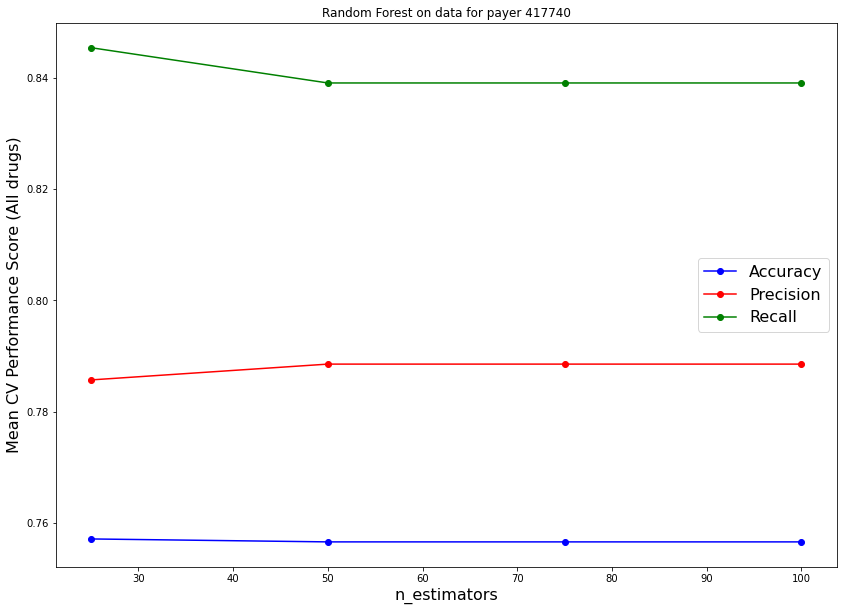

In [12]:
## For only payer 417740
## Performing 10-fold Cross-validation while iterating n_estimators
kfold = StratifiedKFold(n_splits=10,shuffle = True,random_state=440)
trees =np.arange(25,125,25)
accs_rf = np.zeros((10,len(trees)))
precs_rf = np.zeros((10,len(trees)))
recs_rf = np.zeros((10,len(trees)))
for j in range(len(trees)):
    rf_clf = RandomForestClassifier(n_estimators=trees[j-1],random_state=614)
    i=0
    for train_index,test_index in kfold.split(X_drugs_train,y_drugs_train):
        X_train_train,X_train_test = X_drugs_train.iloc[train_index],X_drugs_train.iloc[test_index]
        y_train_train,y_train_test = y_drugs_train.iloc[train_index],y_drugs_train.iloc[test_index]
    ## print(" for iteration",i,"X_train_train is",X_train_train,"and X_train_test is",X_train_test)
    
        rf_clf_clone = clone(rf_clf)
        rf_clf_clone.fit(X_train_train,y_train_train)
        y_predict = rf_clf_clone.predict(X_train_test)
        accs_rf[i,j-1] = accuracy_score(y_train_test,y_predict)
        precs_rf[i,j-1] = precision_score(y_train_test,y_predict)
        recs_rf[i,j-1] = recall_score(y_train_test,y_predict)
        i = i + 1

print("CV Mean Accuracy is",np.mean(accs_rf,axis=0))
print("CV Mean Precision is",np.mean(precs_rf,axis=0))
print("CV Mean Recall is",np.mean(recs_rf,axis=0))
plt.figure(figsize=(14,10))

plt.plot(np.arange(25,125,25), np.mean(accs_rf,axis=0),'b-o', label="Accuracy")
plt.plot(np.arange(25,125,25), np.mean(precs_rf,axis=0),'r-o', label="Precision")
plt.plot(np.arange(25,125,25), np.mean(recs_rf,axis=0),'g-o', label="Recall")

plt.ylabel("Mean CV Performance Score (All drugs)",fontsize=16)
plt.xlabel("n_estimators",fontsize=16)

plt.legend(fontsize=16)
plt.title("Random Forest on data for payer 417740")

plt.show()

CV Mean Accuracy is [0.81405702 0.81408625 0.81404803 0.81404803]
CV Mean Precision is [0.83757636 0.8385674  0.83755334 0.83755334]
CV Mean Recall is [0.92659839 0.92502183 0.926629   0.926629  ]


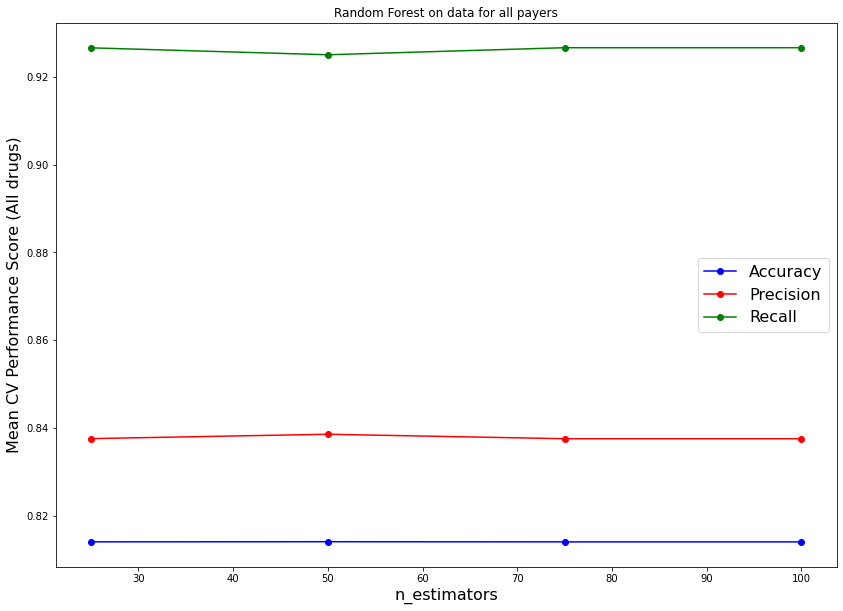

In [13]:
## For all payers combined
## Performing 10-fold Cross-validation while iterating n_estimators
kfold = StratifiedKFold(n_splits=10,shuffle = True,random_state=440)
trees =np.arange(25,125,25)
accs_rf = np.zeros((10,len(trees)))
precs_rf = np.zeros((10,len(trees)))
recs_rf = np.zeros((10,len(trees)))
for j in range(len(trees)):
    rf_clf = RandomForestClassifier(n_estimators=trees[j-1],random_state=614)
    i=0
    for train_index,test_index in kfold.split(X_allpayers_train,y_allpayers_train):
        X_train_train,X_train_test = X_allpayers_train.iloc[train_index],X_allpayers_train.iloc[test_index]
        y_train_train,y_train_test = y_allpayers_train.iloc[train_index],y_allpayers_train.iloc[test_index]
    ## print(" for iteration",i,"X_train_train is",X_train_train,"and X_train_test is",X_train_test)
    
        rf_clf_clone = clone(rf_clf)
        rf_clf_clone.fit(X_train_train,y_train_train)
        y_predict = rf_clf_clone.predict(X_train_test)
        accs_rf[i,j-1] = accuracy_score(y_train_test,y_predict)
        precs_rf[i,j-1] = precision_score(y_train_test,y_predict)
        recs_rf[i,j-1] = recall_score(y_train_test,y_predict)
        i = i + 1

print("CV Mean Accuracy is",np.mean(accs_rf,axis=0))
print("CV Mean Precision is",np.mean(precs_rf,axis=0))
print("CV Mean Recall is",np.mean(recs_rf,axis=0))
plt.figure(figsize=(14,10))

plt.plot(np.arange(25,125,25), np.mean(accs_rf,axis=0),'b-o', label="Accuracy")
plt.plot(np.arange(25,125,25), np.mean(precs_rf,axis=0),'r-o', label="Precision")
plt.plot(np.arange(25,125,25), np.mean(recs_rf,axis=0),'g-o', label="Recall")

plt.ylabel("Mean CV Performance Score (All drugs)",fontsize=16)
plt.xlabel("n_estimators",fontsize=16)
plt.title("Random Forest on data for all payers")

plt.legend(fontsize=16)

plt.show()